In [1]:
%pylab
%matplotlib inline

from scipy.integrate import quad
from scipy import norm
from scipy.stats import gaussian_kde

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [139]:
# reference point
r = np.array([6, 6])

# Pareto-front approximation set
pf = np.array([[3, 4], [1, 5], [5, 1]])

mu = np.array([-1, 4])  # mean of f1 and f2
ss = np.array([.1, .1])  # variance, not std

In [140]:
# Eq.(4)
def original(x, mean, variance, p):
    return (
        np.exp(-0.5 * ((x - mean[0]) ** 2 / variance[0] + (p / x - mean[1]) ** 2 / variance[1]))
        / x
    )

def get_D(L, U, loc, scale):
    return norm.cdf(U, loc, scale) - norm.cdf(L, loc, scale)

def density_in_cell(mean, variance, truncatedLB, truncatedUB, p):
    L1 = truncatedLB[0]
    L2 = truncatedLB[1]
    U1 = truncatedUB[0]
    U2 = truncatedUB[1]

    if L1 * U2 > U1 * L2:  # swap y_1' and y_2'
        L1 = truncatedLB[1]
        L2 = truncatedLB[0]
        U1 = truncatedUB[1]
        U2 = truncatedUB[0]
            mean = mean[1], mean[0]
            variance = variance[1], variance[0]
        
    D1, D2 = get_D(L1, U1, mean[0], variance[0] ** 0.5), get_D(L2, U2, mean[1], variance[1] ** 0.5)

    if L1 * L2 <= p < L1 * U2:
        alpha = L1
        belta = p / L1
    elif L1 * U2 <= p < U1 * L2:
        alpha = p / U2
        belta = p / L2
    elif U1 * L2 <= p <= U1 * U2:
        alpha = p / U2
        belta = U1
    else:
        print("error in lb and ub")

    res = quad(
        original,
        alpha,
        belta,
        args=(mean, variance, p),
        limit=1000,
        epsabs=1e-30,
        epsrel=1e-10
    )[0]
    return res / (2 * np.pi * np.sqrt(variance[0]) * np.sqrt(variance[1]) * D1 * D2)

IndentationError: unexpected indent (<ipython-input-140-cec6b7b3844c>, line 22)

In [141]:
L1, L2, U1, U2 = 0, 0, 0.5, 0.5
pvals = np.linspace(L1 * L2, U1 * U2, 500)
rst_new = [density_in_cell(mu, ss, [L1, L2], [U1, U2], p) for p in pvals]

<ipython-input-117-db341e5bd19b>:29: RuntimeWarning: invalid value encountered in double_scalars
  belta = p / L1
<ipython-input-117-db341e5bd19b>:4: RuntimeWarning: invalid value encountered in double_scalars
  np.exp(-0.5 * ((x - mean[0]) ** 2 / variance[0] + (p / x - mean[1]) ** 2 / variance[1]))
<ipython-input-117-db341e5bd19b>:39: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  res = quad(
<ipython-input-117-db341e5bd19b>:39: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res = quad(


In [71]:
from scipy.stats import norm

def rcond_norm(N, loc, scale, L=1, U=2):
    alpha = norm.cdf(L, loc, scale)
    beta = norm.cdf(U, loc, scale)
    Z = beta - alpha 
    return norm.ppf(np.random.rand(int(N)) * Z + alpha, loc, scale)

assert np.all(rcond_norm(1000, -0.5, 10) >= 1) and np.all(rcond_norm(1000, 20, 10) <= 2)
rcond_norm(10, mu[0], ss[0])

array([1.06996597, 1.01748664, 1.01762758, 1.12745984, 1.27115141,
       1.38897564, 1.32623571, 1.25575454, 1.90657239, 1.06890749])

In [137]:
def sample(mean, variance, lower, upper, N=1e3):
    return rcond_norm(N, mean[0], variance[0] ** 0.5, lower[0], upper[0]) * rcond_norm(N, mean[1], variance[1] ** 0.5, lower[1], upper[1])

# s = sample(mu, ss, (L1, L2), (U1, U2), int(1e6))
# density = gaussian_kde(s)

x = rcond_norm(1e6, mu[0], ss[0] ** 0.5, L1, U1)
y = rcond_norm(1e6, mu[1], ss[1] ** 0.5, L2, U2)

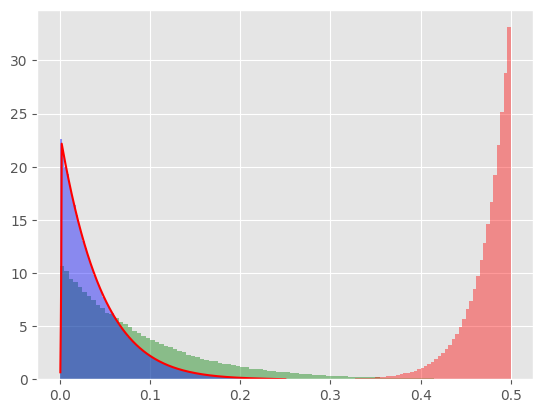

In [142]:
n, bins, patches = plt.hist(x, 100, density=True, facecolor='g', alpha=0.4)
n, bins, patches = plt.hist(y, 100, density=True, facecolor='r', alpha=0.4)
n, bins, patches = plt.hist(x * y, 100, density=True, facecolor='b', alpha=0.4)
plt.plot(pvals, rst_new, 'r-')

In [70]:
from sympy.solvers import solve
from sympy.abc import x, p, s, a, b

expr = (s - 1) + (p ** 2 / b * x ** (-2) - x ** 2/ a)
res = solve((s - 1) + (p ** 2 / b * x ** (-2) - x ** 2/ a), x)

In [71]:
expr = res[3]
expr

sqrt(2)*sqrt(a*s - a + sqrt(a**2*b**2*s**2 - 2*a**2*b**2*s + a**2*b**2 + 4*a*b*p**2)/b)/2

In [72]:
out = [_.subs([[a, 7.96809574e-06], [b, 1.19521436e-05], [s, -15], [p, 0.00019306977288832455]]) for _ in res]
out

[-0.0108117065311*sqrt(2)*I,
 0.0108117065311*sqrt(2)*I,
 -0.00729028340976056*sqrt(2),
 0.00729028340976056*sqrt(2)]

In [73]:
float(out[-1])

0.010310017671626957

In [74]:
integrand1(float(out[-1]), -15)

3.310491898317922e+22